In [439]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline


In [416]:
#to do list
# feature meanings
# autoencoder clustering
# clustering plots
# why cluster with SdA?

In [417]:
# import data
y_all = pd.read_csv('fraudlabels.csv',names=["fraud"])
# feature names and data are in different csv files
with open(r"attributes.csv","r", encoding='utf8') as f:
    cr = csv.reader(f,delimiter=" ")
    features = list(cr)  # create a list of rows for instance
features = [x[0] for x in features]
X_all = pd.read_csv('fraudnumerics.csv',names=features)
# no type conversions required 

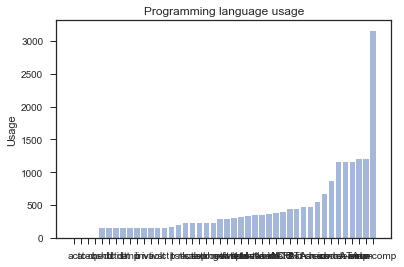

In [418]:
# bar graph for missing values in pandas dataframe
objects = features
y_pos = np.arange(len(objects))
missing = pd.DataFrame({"null":X_all.isnull().sum().sort_values()})
 
plt.bar(y_pos, missing["null"], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()


In [419]:
# count NaN values in each column
missing['missing/total']  = missing['null']/ X_all.shape[0]

print(missing.head())
# A lot of missing data
# going to delete data with more than 25% data missing
# get columns that fit into this category 
# don'tknow the meaning of the features - if given I could make more educated guesses about which columns can be dropped
drop_rate = 0.25
to_drop = missing.index[missing['missing/total'] > drop_rate].tolist()
# check all columns' data types
print(X_all.dtypes.head())
# all column types are numeric

#What is the spread of missing numbers

           null  missing/total
new-comp      0       0.000000
lease-dum     0       0.000000
oplease       0       0.000000
exchg         0       0.000000
at          144       0.045613
act     float64
at      float64
ceq     float64
che     float64
csho    float64
dtype: object


In [420]:
print("X shape: ", X_all.shape)
print("y shape: ",y_all.shape)

#dropping columns with more than 25% of data missing until I find out column labels
X_all = X_all.drop(columns=to_drop)
print("X shape: ", X_all.shape)


X shape:  (3157, 44)
y shape:  (3157, 1)
X shape:  (3157, 37)


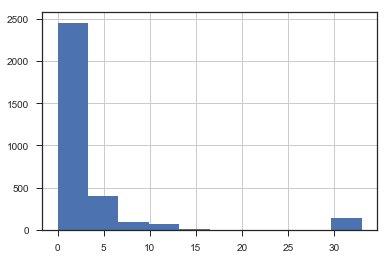

In [421]:
#look at rows with missing data 
X_all.isnull().sum(axis=1).hist()
temp_X = pd.DataFrame({"rownull":X_all.isnull().sum(axis=1)})
#there is a group of ~ 100 row missing 29 or more values
# get index of these rows and drop 
drop_rate_row = 29
# returns which rows to drop in both X and Y dataframe
to_drop = temp_X.index[temp_X['rownull'] > drop_rate_row].tolist()

In [422]:
#how many rows are going to be dropped?
print(len(to_drop))
#axis = 0, dropping rows
X_all = X_all.drop(to_drop,axis=0)
y_all = y_all.drop(to_drop,axis=0)


144


X shape:  (3013, 37)
y shape:  (3013, 1)


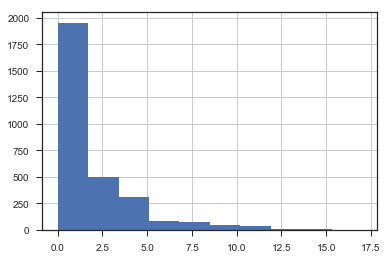

In [423]:
print("X shape: ", X_all.shape)
print("y shape: ",y_all.shape)
X_all.isnull().sum(axis=1).hist()

# IF ROWS BEING DROPPED ARE MOSTLY FRAUDULENT THIS MIGHT BE IMPORTANT need to look into this laters
# now rows are missing at most 15 features out of 37

In [424]:
#Imputing missing values with mean from column
X_all = X_all.fillna(X_all.mean())

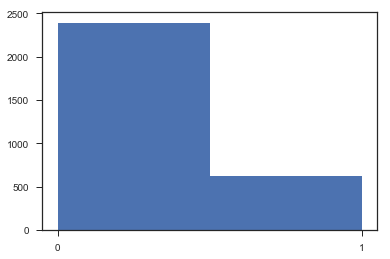

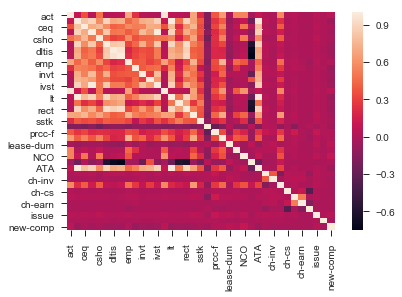

In [425]:
#print(X_all.describe())
# need to add titles to histograms
y = [y_all.fraud.sum(), y_all[y_all.fraud == 0].shape[0]]
plt.hist(y_all, bins=2)
plt.show()
sns.heatmap(X_all.corr())

In [441]:
# do i need to scale data after split .... do i need to split while clustering....
# need to scale the data 
# explain why i chose to use robust scaler (outliers, maybe show graph with outliers before and after)
# find which features have outliers
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
transformer = MinMaxScaler(feature_range=(0, 1)).fit(X_all)
X_sc = transformer.transform(X_all)

In [442]:
#http://www.iro.umontreal.ca/~pift6266/H10/notes/SdA.html

In [443]:
def allHistograms(df):
    for i, col in enumerate(df.columns):
        plt.figure(i)
        plt.hist(df[col])
        plt.title(col)

def pairwiseHistogramsScatter(num_cols, df,y):
    temp = df[df.columns[0:num_cols]]
    temp["fraud"] = y["fraud"]
    g = sns.PairGrid(temp, hue="fraud")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend();

In [444]:
# get features with standard deviation close to zero
X_stats = transformer.transform(X_all)
X_stats = pd.DataFrame(X_stats, columns = X_all.columns)
X_stats = X_all.describe()
X_stats.loc["std"]

act            4265.586291
at           123595.831244
ceq           10011.903703
che           16876.461511
csho            566.652597
dlc           35005.098043
dltis         14179.935274
dltt          28465.742934
emp              39.683611
ib             1849.112707
invt          17931.915520
ivao          35055.592177
ivst          14552.091359
lct            3878.467463
lt           115234.698417
pstk            509.710379
rect          61669.785738
sale          15024.233106
sstk            353.438125
exchg             3.284423
prcc-f           23.360688
oplease         546.897050
lease-dum         0.385260
WC             1046.235741
NCO            7509.103494
FIN           52545.225920
ATA          116909.253769
ch-rec            0.151127
ch-inv            0.119481
cs            17578.508278
ch-cs          1819.658009
earn-ATA          0.864642
ch-earn           0.959606
ch-emp          779.861505
issue             0.235123
bm              217.074355
new-comp         75.785994
N

In [445]:
# Need to split data into train validation test 
X_train, X_test, y_train, y_test = train_test_split(X_all.values, y_all.values, test_size=0.1, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.0, random_state=42)
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_validate_noisy = X_validate + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_validate.shape)
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)


(2711, 37)
(302, 37)
(0, 37)


In [545]:

    
def autoencoder(numFeatures):
    encoding_dim = 64
    #input
    inData = Input(shape=(numFeatures,))
    print(inData)
    act = 'relu'
    #encoding
    encoded = Dense(64, activation='relu',activity_regularizer=regularizers.l1(10e-8),kernel_initializer='random_uniform',
                bias_initializer='random_uniform')(inData)
    encoded = Dense(32, activation=act)(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    #latent layer
    #latent = Dense(2,activation='sigmoid')(encoded)
    #decoding
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(32, activation=act)(decoded)
    decoded = Dense(64, activation='relu')(decoded)
    outData = Dense(numFeatures, activation='relu')(decoded)
    autoencoder = Model(inData, outData)
    return autoencoder


In [551]:
batch_size = 32
epochs = 500
# input shape is 1x# of features
features = X_all.shape[1]
ae = autoencoder(features)
ae.summary()

Tensor("input_98:0", shape=(?, 37), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        (None, 37)                0         
_________________________________________________________________
dense_574 (Dense)            (None, 64)                2432      
_________________________________________________________________
dense_575 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_576 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_577 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_578 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_579 (Dense)        

In [552]:
ae.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [553]:
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)


history = autoencoder_train = ae.fit(x_train_noisy, x_train_noisy, batch_size=batch_size,epochs=epochs,verbose=0,shuffle=True, validation_data=(x_validate_noisy, X_validate),callbacks=[checkpointer, tensorboard]).history


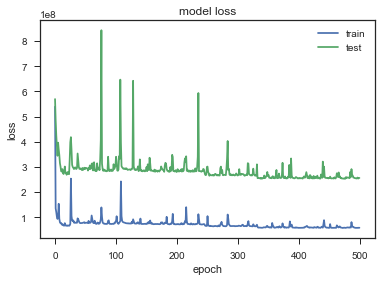

In [554]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

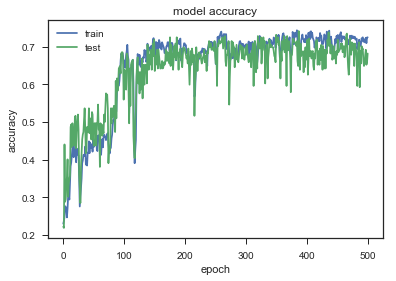

In [555]:
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()